In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tinyAG.engine import Value
from tinyAG.nn import Neuron, Layer, MLP
from tinyAG.losses import *
from tinyAG.datasets import arbt_moons

In [2]:
np.random.seed(1337)
random.seed(1337)

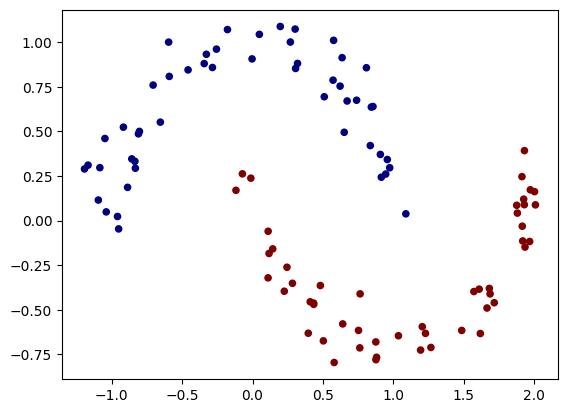

In [5]:
X, y = arbt_moons(n_moons=2, n_samples=100)
y = y*2 - 1

plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [6]:
y

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [7]:
model = MLP(2, [16, 16, 1])
print(model)
print('-----------')
print("number of parameters:", len(model.parameters()))

MLP of [
 Layer of [tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2), tanh Neuron(2)] 
 Layer of [tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16), tanh Neuron(16)] 
 Layer of [linear Neuron(16)] 
]
-----------
number of parameters: 337


In [8]:
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy), scores

total_loss, acc, scores = loss()
print(total_loss, acc)

Value(data=0.8229763928428314) 0.75


In [9]:
epochs = 100

old_loss = 0.0
tot_loss = Value(0.0)
alpha = 1.0
for epoch in range(epochs):

    old_loss = tot_loss.data 
    tot_loss, acc, scores = loss()

    model.zero_grad()
    tot_loss.backward()

    alpha = (alpha * 1e-1) if (tot_loss.data >= old_loss) else alpha
    learning_rate = (1.0 - 9e-1 * epoch / epochs) * alpha
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if epoch != epochs - 1:
        if epoch % (epochs/10) == 0:
            print(f"epoch {epoch} -- loss {tot_loss} -- accuracy {acc*100}")
    else:
        print(f"epoch {epoch} -- loss {tot_loss} -- accuracy {acc*100}")

epoch 0 -- loss Value(data=0.8229763928428314) -- accuracy 75.0
epoch 10 -- loss Value(data=0.18924499083541776) -- accuracy 92.0
epoch 20 -- loss Value(data=0.1606072506111351) -- accuracy 94.0
epoch 30 -- loss Value(data=0.1435201045770233) -- accuracy 96.0
epoch 40 -- loss Value(data=0.13289967875121395) -- accuracy 96.0
epoch 50 -- loss Value(data=0.12400120518800317) -- accuracy 96.0
epoch 60 -- loss Value(data=0.11791039324089582) -- accuracy 96.0
epoch 70 -- loss Value(data=0.11276487339961187) -- accuracy 96.0
epoch 80 -- loss Value(data=0.10863790145105531) -- accuracy 96.0
epoch 90 -- loss Value(data=0.10596275738868402) -- accuracy 96.0
epoch 99 -- loss Value(data=0.10444516813578367) -- accuracy 96.0


(-1.795841816214646, 1.954158183785354)

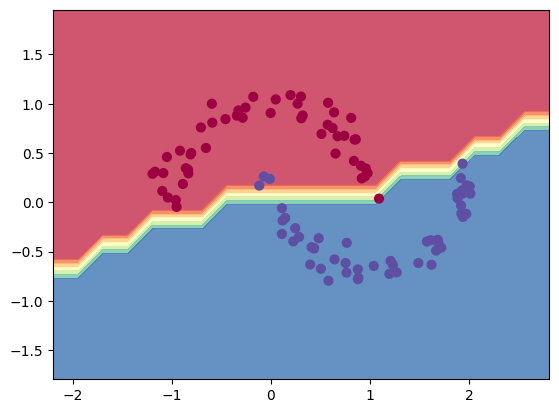

In [10]:

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([(s.data>0) for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())